In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
import json
import glob

import time
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 12)

In [6]:
"""
load tinyimage net dataset and return 

Parameters:
----------
data_folder: directory to tiny imagenet
size: the pixel size for each image
batch_size: number of images per batch
num_works: set # of works simultaneously inputting data
----------

Returns:
----------
data_loader: returns pytorch object of the respective three datasets, 'train', 'val', and 'test'
dataset_sizes: returns dict of sizes
classes: returns list of all used in label IDs
----------

"""
def load_data(data_folder = '', size = 150, batch_size = 32, num_workers = 8):
    data_transforms = {
        'train': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    }

    imagenets = {
        'train': ImageFolder(data_folder + '/train', transform=data_transforms['train']),
        'val': ImageFolder(data_folder + '/val', transform=data_transforms['val']),
        'test': ImageFolder(data_folder + '/test', transform=data_transforms['test'])
    }

    data_loader = {
        x: torch.utils.data.DataLoader(imagenets[x],
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=num_workers) for x in ['train', 'val', 'test']
    }
    dataset_sizes = {x: len(imagenets[x]) for x in ['train', 'val', 'test']}
    print('Datasets Loaded')
    classes = imagenets['train'].classes
    
    return data_loader, dataset_sizes, classes

In [7]:
"""
load label IDs and match them with their description

Parameters:
----------
label_folder: directory to words.txt within the tiny imagenet directory
----------

Returns:
----------
labels_list: returns a list of just the descriptions of all IDs
labels_dict: returns dict of the list above, but matched with its ID
----------

"""
def load_labels(label_folder = ''):
    f = open(label_folder, "r")
    labels_dict = {}
    labels_list = []
    for line in f:
        split = line.split(maxsplit=1)
        split[1] = split[1][:-1]
        label_id, label = split[0], split[1]
        labels_dict[label_id] = label.split(',')[0]
        labels_list.append(split[1])
    return labels_list, labels_dict

In [8]:
"""
Get label description based on index. Index number represents where it lies in 'classes' array. 
Using a dict we can return a description rather than an ID.

Parameters:
----------
x: index in classes array, to be transformed to description
----------

Returns:
----------
label: returns a string of more than 1 word replacing the ID
----------

"""
def get_label(x):
    label = labels_dict[classes[x]]
    return label

In [9]:
"""
Denormalize our images due to our preprocessing early, and convert them to numpy arrays to be viewed using matplotlib.

Parameters:
----------
img: tensor object representing the image
title: caption/title of that specific image
----------
"""
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #Pause is necessary to display images correctly

In [26]:
data,sizes,classes = load_data('tinyimage10')
data

Datasets Loaded


{'train': <torch.utils.data.dataloader.DataLoader at 0x23152060c18>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x23152060748>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x23152034160>}

In [27]:
labels_list, labels_dict = load_labels("tinyimage10\\words.txt")
print(labels_list[1:4])

['physical entity', 'abstraction, abstract entity', 'thing']


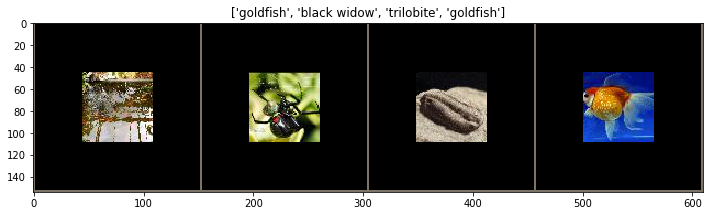

In [12]:
# Get a batch of training data
inputs, labels_id = next(iter(data['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4], nrow = 4)

imshow(out, title=[get_label(x) for x in labels_id[0:4]])

In [13]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes=200):
        
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
            
           nn.Conv2d(64, 192, kernel_size=5, padding=2),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
            
           nn.Conv2d(192, 384, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
        
           nn.Conv2d(384, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
            
           nn.Conv2d(256, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.fc = nn.Sequential(
           nn.Dropout(),
           nn.Linear(256*6*6, 4096),
           nn.ReLU(inplace=True),
           
           nn.Dropout(),
           nn.Linear(4096, 4096),
           nn.ReLU(inplace=True),
         
           nn.Linear(4096, num_classes),
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.fc(x)   
        return x
    
model = AlexNet()
writer = SummaryWriter('runs/AlexNet_experiment_1')
model

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU

In [14]:
# We train everything on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Cross entropy loss takes the logits directly, so we don't need to apply softmax in our CNN
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30,gamma=0.1)

model = model.to(device)

cuda


In [15]:
def train(model, data_loader, loss_func, scheduler, optimizer, num_epochs=20, print_freq=200):
    
    since = time.time()
    
    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # You perform validation test after every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0 
                
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero accumulated gradients
                optimizer.zero_grad()
                
                # During train phase we want to remember history for grads
                # and during val we do not want history of grads
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if i%print_freq == 0:
                        train_batch_loss.append(loss.item())
                        print('Epoch {}: {}/{} step in progress'.format(epoch+1, i, len(data_loader['train'])))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    writer.add_scalar('training loss',
                    running_loss,
                    epoch * len(data_loader) + i)

                if phase == 'val':
                    writer.add_scalar('val loss',
                    running_loss,
                    epoch * len(data_loader) + i)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_epoch_loss.append((epoch_loss, epoch_acc))
                writer.add_scalar('val acc',
                epoch_acc,
                epoch)
                scheduler.step(loss.item())
            else:
                train_epoch_loss.append((epoch_loss, epoch_acc))
                writer.add_scalar('train acc',
                epoch_acc,
                epoch)
                scheduler.step(loss.item())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    loss = [train_epoch_loss, val_epoch_loss]
    
    return model, loss

In [23]:
m, loss = train(model, data, loss_func, scheduler, optimizer, num_epochs=150)

Epoch 1/150
---------------
Epoch 1: 0/125 step in progress
train Loss: 0.5186 Acc: 0.8247
Epoch 1: 0/125 step in progress
val Loss: 2.0773 Acc: 0.4880

Epoch 2/150
---------------
Epoch 2: 0/125 step in progress
train Loss: 0.4851 Acc: 0.8360
Epoch 2: 0/125 step in progress
val Loss: 2.0107 Acc: 0.5300

Epoch 3/150
---------------
Epoch 3: 0/125 step in progress
train Loss: 0.4845 Acc: 0.8293
Epoch 3: 0/125 step in progress
val Loss: 2.2071 Acc: 0.5260

Epoch 4/150
---------------
Epoch 4: 0/125 step in progress
train Loss: 0.4806 Acc: 0.8327
Epoch 4: 0/125 step in progress
val Loss: 2.1431 Acc: 0.5140

Epoch 5/150
---------------
Epoch 5: 0/125 step in progress
train Loss: 0.4132 Acc: 0.8635
Epoch 5: 0/125 step in progress
val Loss: 2.2793 Acc: 0.4960

Epoch 6/150
---------------
Epoch 6: 0/125 step in progress
train Loss: 0.4188 Acc: 0.8573
Epoch 6: 0/125 step in progress
val Loss: 2.2187 Acc: 0.5140

Epoch 7/150
---------------
Epoch 7: 0/125 step in progress
train Loss: 0.4431 Acc

Epoch 53: 0/125 step in progress
val Loss: 3.2041 Acc: 0.5180

Epoch 54/150
---------------
Epoch 54: 0/125 step in progress
train Loss: 0.1105 Acc: 0.9670
Epoch 54: 0/125 step in progress
val Loss: 3.3978 Acc: 0.5100

Epoch 55/150
---------------
Epoch 55: 0/125 step in progress
train Loss: 0.0451 Acc: 0.9880
Epoch 55: 0/125 step in progress
val Loss: 3.8426 Acc: 0.5420

Epoch 56/150
---------------
Epoch 56: 0/125 step in progress
train Loss: 0.1073 Acc: 0.9698
Epoch 56: 0/125 step in progress
val Loss: 3.4035 Acc: 0.5240

Epoch 57/150
---------------
Epoch 57: 0/125 step in progress
train Loss: 0.1209 Acc: 0.9665
Epoch 57: 0/125 step in progress
val Loss: 2.8912 Acc: 0.5240

Epoch 58/150
---------------
Epoch 58: 0/125 step in progress
train Loss: 0.0868 Acc: 0.9785
Epoch 58: 0/125 step in progress
val Loss: 3.6176 Acc: 0.5340

Epoch 59/150
---------------
Epoch 59: 0/125 step in progress
train Loss: 0.0666 Acc: 0.9783
Epoch 59: 0/125 step in progress
val Loss: 3.2434 Acc: 0.5140

E

Epoch 106/150
---------------
Epoch 106: 0/125 step in progress
train Loss: 0.0640 Acc: 0.9803
Epoch 106: 0/125 step in progress
val Loss: 3.3721 Acc: 0.5280

Epoch 107/150
---------------
Epoch 107: 0/125 step in progress
train Loss: 0.0687 Acc: 0.9820
Epoch 107: 0/125 step in progress
val Loss: 3.1499 Acc: 0.5380

Epoch 108/150
---------------
Epoch 108: 0/125 step in progress
train Loss: 0.0365 Acc: 0.9895
Epoch 108: 0/125 step in progress
val Loss: 3.8032 Acc: 0.5140

Epoch 109/150
---------------
Epoch 109: 0/125 step in progress
train Loss: 0.0321 Acc: 0.9898
Epoch 109: 0/125 step in progress
val Loss: 4.1196 Acc: 0.5140

Epoch 110/150
---------------
Epoch 110: 0/125 step in progress
train Loss: 0.0386 Acc: 0.9888
Epoch 110: 0/125 step in progress
val Loss: 3.8010 Acc: 0.5280

Epoch 111/150
---------------
Epoch 111: 0/125 step in progress
train Loss: 0.0772 Acc: 0.9805
Epoch 111: 0/125 step in progress
val Loss: 3.4060 Acc: 0.5280

Epoch 112/150
---------------
Epoch 112: 0/125

In [24]:
# Get test accuracy.
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(data['test']):
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [25]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(data['test']):
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [22]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        labels_dict[classes[i]], 100 * class_correct[i] / class_total[i]))

Accuracy of goldfish : 85 %
Accuracy of European fire salamander : 66 %
Accuracy of bullfrog : 56 %
Accuracy of tailed frog : 53 %
Accuracy of American alligator : 60 %
Accuracy of boa constrictor : 23 %
Accuracy of trilobite : 42 %
Accuracy of scorpion : 26 %
Accuracy of black widow : 53 %
Accuracy of tarantula : 27 %
